# Testando K-means, para agrupar e gerar insights do conjunto de dados

## Importando bibliotecas e limpando os dados

In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
df = pd.read_csv("../Arthur_lanches_games_CSVs/LoadDataSetArthurLanches.csv")

In [23]:
df.head()

,matchId,queueId,gameDuration,summonerName,teamId,championName,kills,deaths,assists,kda,...,firstBloodAssist,firstBloodKill,champExperience,doubleKills,tripleKills,quadraKills,pentaKills,win,gameDurationMin,gameStartTime
0,BR1_3066283114,420,1696,NaN,0,Teemo,6,7,9,2.14,...,False,False,15186,1,0,0,0,False,28.3,2025-02-13 21:02:46.908
1,BR1_3066260304,420,1484,NaN,0,Teemo,6,2,8,7.00,...,False,False,15123,0,0,0,0,True,24.7,2025-02-13 19:54:01.545
2,BR1_3066246152,420,1969,NaN,0,Teemo,5,4,11,4.00,...,True,False,16909,0,0,0,0,True,32.8,2025-02-13 19:08:13.973
3,BR1_3066231574,420,1409,NaN,1,Teemo,0,5,5,1.00,...,False,False,12355,0,0,0,0,False,23.5,2025-02-13 18:23:59.796
4,BR1_3065897622,420,1760,NaN,0,Teemo,3,8,7,1.25,...,False,False,12672,0,0,0,0,False,29.3,2025-02-12 18:45:03.944


In [24]:
df.drop(columns=['queueId', 'summonerName', 'matchId', 'pentaKills', 'gameStartTime'], inplace=True)
df = df.drop_duplicates().reset_index(drop=True)
le = LabelEncoder()
df['championNameEncoded'] = le.fit_transform(df['championName'])
df.drop(columns={'championName'},inplace=True)
dict(zip(le.classes_,le.transform(le.classes_)))

{'Gnar': np.int64(0),
 'JarvanIV': np.int64(1),
 'Karma': np.int64(2),
 'Kennen': np.int64(3),
 'Leona': np.int64(4),
 'Malphite': np.int64(5),
 'Nami': np.int64(6),
 'Orianna': np.int64(7),
 'Ornn': np.int64(8),
 'Quinn': np.int64(9),
 'Skarner': np.int64(10),
 'TahmKench': np.int64(11),
 'Teemo': np.int64(12),
 'Varus': np.int64(13)}

In [25]:
df.columns

Index(['gameDuration', 'teamId', 'kills', 'deaths', 'assists', 'kda',
       'totalMinionsKilled', 'totalDamageTaken', 'totalDamageDealtToChampions',
       'goldEarned', 'visionScore', 'summoner1Id', 'summoner2Id',
       'firstTowerKill', 'firstBloodAssist', 'firstBloodKill',
       'champExperience', 'doubleKills', 'tripleKills', 'quadraKills', 'win',
       'gameDurationMin', 'championNameEncoded'],
      dtype='object')

## Testando o K-means para agrupar as features

Explained variance ratio: [0.35023949 0.1096288 ]


Silhouette scores: {2: np.float64(0.2245461675629573), 3: np.float64(0.14794632331503818), 4: np.float64(0.15716228188379705), 5: np.float64(0.13430042654189583)}


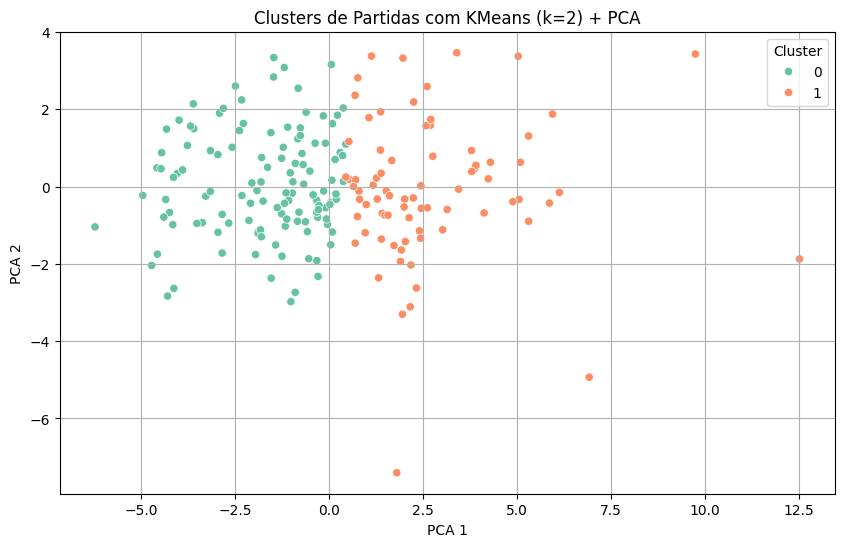

In [26]:
# Garantindo que as colunas booleanas sejam int
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

# Selecionando features 
feature_cols = [c for c in df.columns if c not in ['win']]
X = df[feature_cols]

# Padronização dos dados com o Scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Técnica de PCA para vizualização
dim_reducer = PCA(n_components=2, random_state=42)
X_pca = dim_reducer.fit_transform(X_scaled)
print("Explained variance ratio:", dim_reducer.explained_variance_ratio_)

# Função para determinar o melhor número de k usando Silhouette Score
sil_scores = {}
for k in range(2, 6):
    km_tmp = KMeans(n_clusters=k, random_state=42)
    labels_tmp = km_tmp.fit_predict(X_scaled)
    sil_scores[k] = silhouette_score(X_scaled, labels_tmp)
print("Silhouette scores:", sil_scores)

# Clustering final com o valor de k encontrado
best_k = max(sil_scores, key=sil_scores.get)
kmeans = KMeans(n_clusters=best_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Adicionando o PCA para plot
df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

# Visualização dos clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='Set2')
plt.title(f'Clusters de Partidas com KMeans (k={best_k}) + PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [27]:
# Taxa de vitória por cluster
print(df.groupby('cluster')['win'].mean())
df['cluster'].value_counts()

cluster
0    0.598361
1    0.662338
Name: win, dtype: float64


cluster
0    122
1     77
Name: count, dtype: int64


Centróides
   gameDuration    teamId     kills    deaths    assists       kda  \
0   1405.680328  0.557377  4.024590  2.672131   4.754098  4.858197   
1   2075.506494  0.389610  8.012987  4.623377  10.415584  5.633117   

   totalMinionsKilled  totalDamageTaken  totalDamageDealtToChampions  \
0          165.467213      14588.139344                 18026.081967   
1          227.870130      27862.779221                 38997.246753   

     goldEarned  ...  summoner2Id  firstTowerKill  firstBloodAssist  \
0   9353.803279  ...    13.434426        0.122951          0.016393   
1  14817.571429  ...    13.259740        0.168831          0.090909   

   firstBloodKill  champExperience  doubleKills   tripleKills   quadraKills  \
0        0.090164     12241.024590     0.196721 -2.081668e-17  5.204170e-18   
1        0.103896     19132.415584     0.727273  1.168831e-01  1.298701e-02   

   gameDurationMin  championNameEncoded  
0        23.423770            11.016393  
1        34.593506      

/var/folders/41/l60nv4zj1zg_h8cs5kvtmf9m0000gn/T/ipykernel_59154/956422504.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_0, data_1], labels=['Cluster 0','Cluster 1'])


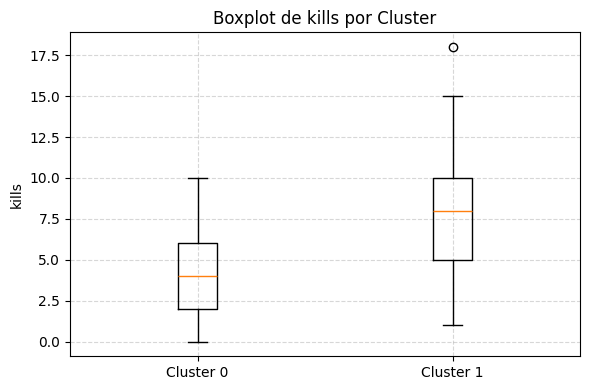

/var/folders/41/l60nv4zj1zg_h8cs5kvtmf9m0000gn/T/ipykernel_59154/956422504.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_0, data_1], labels=['Cluster 0','Cluster 1'])


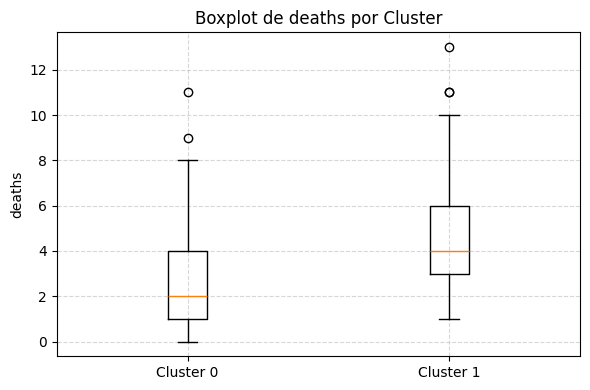

/var/folders/41/l60nv4zj1zg_h8cs5kvtmf9m0000gn/T/ipykernel_59154/956422504.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_0, data_1], labels=['Cluster 0','Cluster 1'])


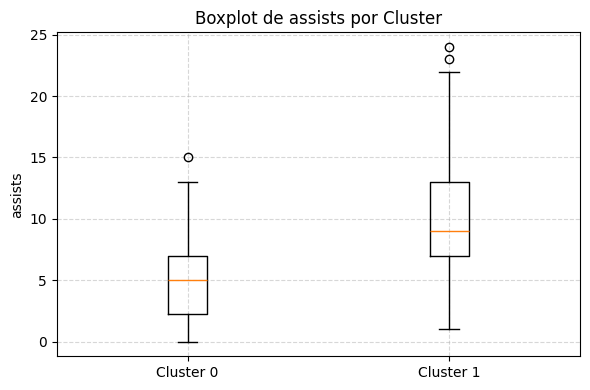

/var/folders/41/l60nv4zj1zg_h8cs5kvtmf9m0000gn/T/ipykernel_59154/956422504.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_0, data_1], labels=['Cluster 0','Cluster 1'])


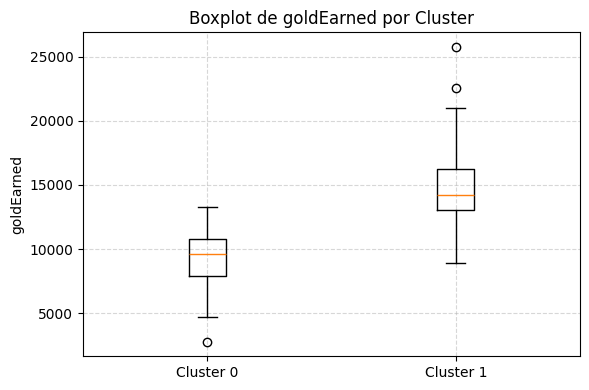

/var/folders/41/l60nv4zj1zg_h8cs5kvtmf9m0000gn/T/ipykernel_59154/956422504.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_0, data_1], labels=['Cluster 0','Cluster 1'])


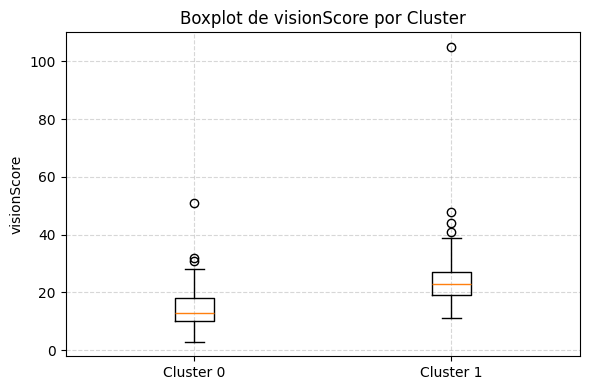

/var/folders/41/l60nv4zj1zg_h8cs5kvtmf9m0000gn/T/ipykernel_59154/956422504.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_0, data_1], labels=['Cluster 0','Cluster 1'])


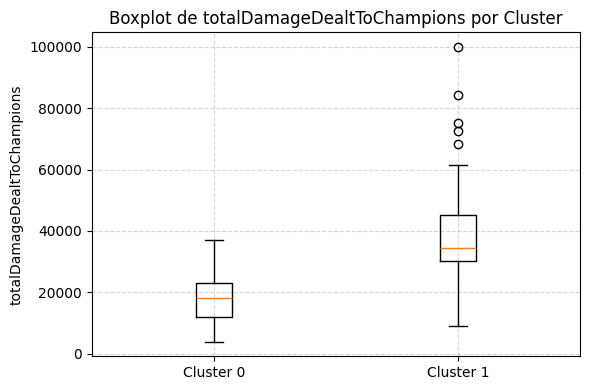

/var/folders/41/l60nv4zj1zg_h8cs5kvtmf9m0000gn/T/ipykernel_59154/956422504.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_0, data_1], labels=['Cluster 0','Cluster 1'])


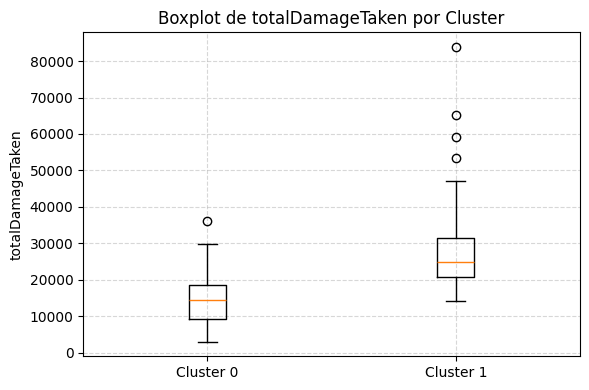

/var/folders/41/l60nv4zj1zg_h8cs5kvtmf9m0000gn/T/ipykernel_59154/956422504.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_0, data_1], labels=['Cluster 0','Cluster 1'])


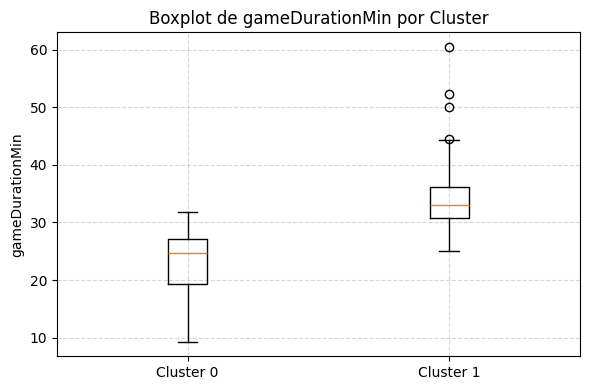

/var/folders/41/l60nv4zj1zg_h8cs5kvtmf9m0000gn/T/ipykernel_59154/956422504.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_0, data_1], labels=['Cluster 0','Cluster 1'])


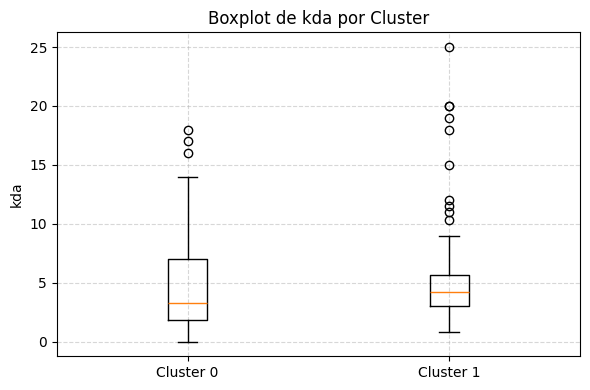

In [28]:
# Centroides desnormalizados
centers_std = kmeans.cluster_centers_
centers_orig = scaler.inverse_transform(centers_std)
centroids = pd.DataFrame(centers_orig, columns=feature_cols)
print("\nCentróides")
print(centroids)

# Médias das features por cluster
means = df.groupby('cluster')[feature_cols].mean()
print("\nMédias por Cluster")
print(means)

# Boxplot de cada métrica
metrics = [
    'kills', 'deaths', 'assists', 'goldEarned', 'visionScore',
    'totalDamageDealtToChampions', 'totalDamageTaken',
    'gameDurationMin', 'kda'
]

for metric in metrics:
    plt.figure(figsize=(6,4))
    data_0 = df[df['cluster']==0][metric]
    data_1 = df[df['cluster']==1][metric]
    plt.boxplot([data_0, data_1], labels=['Cluster 0','Cluster 1'])
    plt.title(f'Boxplot de {metric} por Cluster')
    plt.ylabel(metric)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

## Insights retirados 

- Sobre o perfil de cada cluster :
    - Cluster 1 representa partidas mais longas em que o jogador tem muito mais participação em kills/assists, coleta de recursos (farm, ouro) e controle de mapa (vision score).
    - Apesar de morrerem um pouco mais (4,6 vs 2,7 mortes), eles compensam com um KDA superior e muito mais dano infligido.
    - Há também maior envolvimento em objetivos iniciais (torres e assistências de first blood).

- Contudo os clusters por taxa de vitória tiveram esses resultados: 0    0.598361,1    0.662338
    - Em resumo, partidas mais longas e que o jgoador tem um KDA maior, além de mais visão e recursos,
o jogador arthur lanches mostra maior taxa de vitórias, por ser um monochampion de teemo, faz bastante sentido devido o campeão ser bom para segurar jogos por mais tempos e também muito forte quanto mais tempo passa de partida, mostrando que os Insights retirados da parte de EDA estavam corretos.